In [2]:
from importlib.metadata import version
import nltk
from nltk.corpus import stopwords
import tensorflow
import summa
from summa.summarizer import summarize
import pandas as pd
import urllib.request
import os
from bs4 import BeautifulSoup 
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

In [3]:
ppsOk = True

In [4]:

# 데이터 전처리 함수
def preprocess_sentence(sentence, contractions, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


#설정 샘플 비율 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


def decode_sequence(encoder_model, decoder_model, input_seq, tar_word_to_index):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq, src_index_to_word):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq, tar_index_to_word):
    temp=''
    for i in input_seq:
        if (i!=0 and i!=1 and i!=2):
            temp = temp + tar_index_to_word[i]+' '
    return temp


In [5]:
try : 
    print('불용어 확인 :', len(stopwords.words('english') ))

except:
    nltk.download('stopwords')

# news_summary_more.csv
try:
    if not os.path.isfile('./news_summary_more.csv'):
        print("download : news_summary_more.csv")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

    data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

except:
    print("error : failed to read file")

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


download : news_summary_more.csv


In [6]:
print(data.sample(10))

                                               headlines  \
5079   UP government contractor shot dead at home, BJ...   
18761  Amazon hits $1 trillion market capitalisation ...   
42398  16-yr-old Indian shooter wins gold on last sho...   
49668  Stone tools in India hint earlier human exit f...   
82859  Alibaba, Tencent among World's Smartest Compan...   
93979  MTV Awards to combine Best Actor, Actress into...   
30451  Today not important, future is: Kumaraswamy on...   
18662  Not proud of new form of low humour: iPhone au...   
17072  Is it a crime: BJP worker who washed MP's feet...   
5073   It took 1.5yrs for Sonia to wish Modi on becom...   

                                                    text  
5079   A government contractor was shot dead at his r...  
18761  World's richest man Jeff Bezos-led e-commerce ...  
42398  India's 16-year-old shooter Manu Bhaker won a ...  
49668  Indian scientists have discovered stone tools ...  
82859  Alibaba and Tencent are among the sev

In [7]:
# 전처리
# 전처리 > 분석
# 전처리 > 분석 > 데이터 타입, null, 확인
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
None


In [8]:
# 전처리 > 분석 > 형태 확인
print(data.shape)

(98401, 2)


In [9]:
# 전처리 > 정제
# 전처리 > 정제 > 중복 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [10]:
# 전처리 > 정제 > 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복 제거 전체 샘플수 :', (len(data)))

중복 제거 전체 샘플수 : 98360


In [11]:
# 전처리 > 정제 > null 확인
print(data.isnull().sum()) # null 없음

headlines    0
text         0
dtype: int64


In [12]:
# 전처리 > 정제 > null 제거
data.dropna(axis=0, inplace=True)
print('null 제거 전체 샘플수 :', (len(data)))

null 제거 전체 샘플수 : 98360


In [13]:
# 전처리 > 정규화
# 전처리 > 정규화 > 정규화 사전 생성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                    "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
# 전처리 > 불용어 제거
# 전처리 > 불용어 제거 > 불용어 정보 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [15]:
# 정규화, 전처리 실행
clean_text = []
clean_summary = []

for _, row in data.iterrows():
    clean_text.append(preprocess_sentence(row["text"], contractions))
    clean_summary.append(preprocess_sentence(row["headlines"],contractions, False))

data['text'] = clean_text
data['headlines'] = clean_summary

In [16]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
# 빈 값 생성 확인
print(data.isnull().sum()) # 빈 값 없음

headlines    0
text         0
dtype: int64


In [18]:
# null 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [19]:
print(data.head(2))

                                           headlines  \
0  upgrad learner switches to career in ml al wit...   
1  delhi techie wins free food from swiggy for on...   

                                                text  
0  saurav kant alumnus upgrad iiit pg program mac...  
1  kunal shah credit card bill payment platform c...  


In [20]:
# 전처리 > 데이터셋 분리
# 전처리 > 데이터셋 분리 > 분리 데이터 정보 확인
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

In [21]:
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


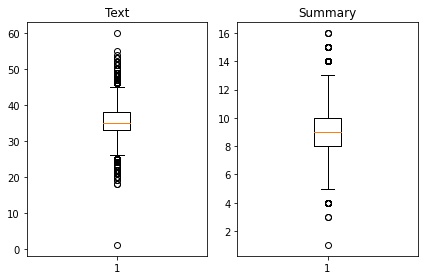

In [22]:
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

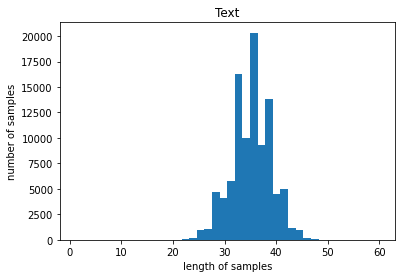

In [23]:
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

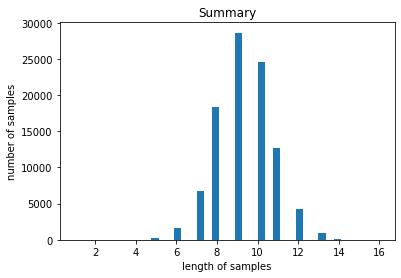

In [24]:
plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
# 전처리 > 데이터셋 분리 > 분리 데이터 단어 개수 제한
text_max_len = 45
summary_max_len = 13
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [26]:
print('전체 샘플수(가공전) :', (len(data)))
data = data[data["text"].apply(lambda x: len(x.split()) < text_max_len)]
print('전체 샘플수(text 제거) :', (len(data)))
data = data[data["headlines"].apply(lambda x: len(x.split()) < summary_max_len)]
print('전체 샘플수(summary 제거) :', (len(data)))

전체 샘플수(가공전) : 98360
전체 샘플수(text 제거) : 97708
전체 샘플수(summary 제거) : 96538


In [27]:
# 전처리 > 데이터셋 분리 > 시작, 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
print(data.head())

                                           headlines  \
0  upgrad learner switches to career in ml al wit...   
2  new zealand end rohit sharma led india match w...   
3  aegon life iterm insurance plan helps customer...   
5  rahat fateh ali khan denies getting notice for...   
6  india get all out for their lowest odi total i...   

                                                text  \
0  saurav kant alumnus upgrad iiit pg program mac...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
5  pakistani singer rahat fateh ali khan denied r...   
6  india recorded lowest odi total new zealand ge...   

                                       decoder_input  \
0  sostoken upgrad learner switches to career in ...   
2  sostoken new zealand end rohit sharma led indi...   
3  sostoken aegon life iterm insurance plan helps...   
5  sostoken rahat fateh ali khan denies getting n...   
6  sostoken india get all out for their lowest

In [28]:
# 전처리 > 데이터셋 분리 > 분리를 위해 numpy array 변환
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [29]:
# 전처리 > 데이터셋 분리 > 데이터 shuffle
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [31]:
# 전처리 > 데이터셋 분리 > 데이터 8:2 분할
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19307


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

In [33]:
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [34]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77231
훈련 레이블의 개수 : 77231
테스트 데이터의 개수 : 19307
테스트 레이블의 개수 : 19307


In [35]:
# 전처리 > 인코딩
# 전처리 > 인코딩 > vocabulary 생성 - text data
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [36]:
# 전처리 > 인코딩 > 빈도 확인 - text data
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [37]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [38]:
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68956
등장 빈도가 6번 이하인 희귀 단어의 수: 46991
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21965
단어 집합에서 희귀 단어의 비율: 68.14635419687917
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5167077522625405


In [39]:
# 전처리 > 인코딩 > 단어 집합 크기 제한 - text data
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환 - text data
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [41]:
# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])  

[[5, 641, 311, 1819, 4059, 6724, 2572, 2219, 4151, 605, 1065, 1136, 3532, 2357, 526, 226, 1, 86, 99, 5, 2325, 688, 279, 33, 43, 98, 2101, 350, 418, 688, 1075, 2071, 138, 17, 581, 123, 237, 379, 605, 1065, 377], [1667, 155, 887, 7087, 190, 502, 19, 4680, 155, 3367, 18, 155, 5229, 12, 6049, 67, 1550, 94, 3791, 307, 4257, 3107, 502, 585, 25, 4680, 7464, 6473, 6049, 456], [588, 2459, 108, 1122, 1036, 4861, 4185, 964, 388, 3696, 1088, 1123, 3256, 4902, 658, 1, 193, 235, 2459, 1227, 151, 2514, 326, 388, 4, 4681, 1376, 1258, 420, 4448, 3436]]


In [48]:
# 전처리 > 인코딩 > vocabulary 생성 - headlines data
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [49]:
# 전처리 > 인코딩 > 빈도 확인 - headlines data
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [50]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [51]:
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29861
등장 빈도가 5번 이하인 희귀 단어의 수: 19549
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10312
단어 집합에서 희귀 단어의 비율: 65.46666220153378
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.732454655258676


In [52]:
# 전처리 > 인코딩 > 단어 집합 크기 제한 - headlines data
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [53]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [54]:
# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 514, 6, 445, 111, 225, 34], [1, 1706, 188, 116, 127, 4, 27, 12, 31], [1, 922, 1873, 6, 36, 1282, 4, 546], [1, 651, 72, 4, 248], [1, 110, 38, 183, 10, 368, 4]]
target
decoder  [[514, 6, 445, 111, 225, 34, 2], [1706, 188, 116, 127, 4, 27, 12, 31, 2], [922, 1873, 6, 36, 1282, 4, 546, 2], [651, 72, 4, 248, 2], [110, 38, 183, 10, 368, 4, 2]]


In [55]:
# 전처리 > 인코딩 > 길이가 0 된 데이터 확인 및 삭제 
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [56]:
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 11
삭제할 테스트 데이터의 개수 : 4


In [57]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

In [58]:
encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

In [59]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77220
훈련 레이블의 개수 : 77220
테스트 데이터의 개수 : 19303
테스트 레이블의 개수 : 19303


In [60]:
# 전처리 > 인코딩 > 단어 길이를 최대 길이로 맞추기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [61]:
# 모델 생성 
# 모델 생성 > 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

In [62]:
# 인코더
encoder_inputs = Input(shape=(text_max_len,))

In [63]:
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

In [64]:
# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

In [65]:
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

In [66]:
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [67]:
# 모델 생성 > 디코더 설계
decoder_inputs = Input(shape=(None,))

In [68]:
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

In [69]:
# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [70]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [71]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [72]:
# 모델 생성 > 어텐션
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

In [73]:
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

In [74]:
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [75]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [76]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [79]:
# 모델 학습
# 모델 학습 > 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# 모델 학습 > 모델 조기 종료
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [78]:
# 모델 학습 > 모델 fit
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
        validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
        batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
302/302 [==============================] - 30s 76ms/step - loss: 3.5876 - val_loss: 3.2998
Epoch 2/50
302/302 [==============================] - 22s 72ms/step - loss: 3.1390 - val_loss: 3.0061
Epoch 3/50
302/302 [==============================] - 22s 73ms/step - loss: 2.9013 - val_loss: 2.8229
Epoch 4/50
302/302 [==============================] - 22s 74ms/step - loss: 2.7270 - val_loss: 2.6920
Epoch 5/50
302/302 [==============================] - 22s 74ms/step - loss: 2.5929 - val_loss: 2.5892
Epoch 6/50
302/302 [==============================] - 22s 73ms/step - loss: 2.4847 - val_loss: 2.5166
Epoch 7/50
302/302 [==============================] - 22s 73ms/step - loss: 2.3956 - val_loss: 2.4553
Epoch 8/50
302/302 [==============================] - 22s 74ms/step - loss: 2.3189 - val_loss: 2.4083
Epoch 9/50
302/302 [==============================] - 22s 73ms/step - loss: 2.2530 - val_loss: 2.3665
Epoch 10/50
302/302 [==============================] - 22s 73ms/step - loss: 2.195

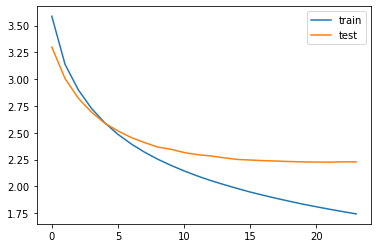

In [80]:
# 모델 평가
# 모델 평가 > 훈련 데이터의 손실과 검증 데이터 시각화
# 모델 평가 > train loss와 validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [81]:
# 인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [82]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [83]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

In [84]:
dec_emb2 = dec_emb_layer(decoder_inputs)

In [85]:
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [86]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [87]:
# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

In [88]:
# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [105]:
# Abstractive 요약 분석
print("Abstractive")
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i], src_index_to_word).strip())
    print("실제 요약 :", seq2summary(decoder_input_test[i], tar_index_to_word).strip())
    print("예측 요약 :", decode_sequence(encoder_model, decoder_model, encoder_input_test[i].reshape(1, text_max_len), tar_word_to_index).strip())
    print("\n")

Abstractive
원문 : british roger oscar best category film runner th academy awards nominated times previously runner also award best effects award show first oscar nomination film
실제 요약 : wins award after losing times in past
예측 요약 : named best actor at


원문 : australian cricket team slipped two places fifth rank icc test team rankings losing two match test series pakistan margin friday australia started second test india south africa loss saw england new zealand reach third fourth place respectively
실제 요약 : aus to th after test series loss against pakistan
예측 요약 : australia australia australia to take lead in test series


원문 : man allegedly attacked wife relatives outside hyderabad police station thursday went register complaint harassment police said couple married since living separately eight months wife relatives injured attack
실제 요약 : man attacks wife with outside hyderabad police station
예측 요약 : man wife wife with police station


원문 : people injured stone pelting festival held u

In [106]:
'''
summarize parameter
text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
'''

'\nsummarize parameter\ntext (str) : 요약할 테스트.\nratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값\nwords (int or None, optional) – 출력에 포함할 단어 수.\n만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.\nsplit (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환\n'

In [215]:
# Extractive 요약 
print("Extractive")
for i in range(50, 100):
    text = seq2text(encoder_input_test[i], src_index_to_word)
    print(len(text))
    print("원문 :", text)
    print("요약 :", summarize(text)) # summarize 해당 text에 작동 안함
    print("\n")

Extractive
161
원문 : british roger oscar best category film runner th academy awards nominated times previously runner also award best effects award show first oscar nomination film 
요약 : 


245
원문 : australian cricket team slipped two places fifth rank icc test team rankings losing two match test series pakistan margin friday australia started second test india south africa loss saw england new zealand reach third fourth place respectively 
요약 : 


209
원문 : man allegedly attacked wife relatives outside hyderabad police station thursday went register complaint harassment police said couple married since living separately eight months wife relatives injured attack 
요약 : 


183
원문 : people injured stone pelting festival held uttarakhand called participants enter ground singing dancing carry wooden protect try hit others held every year festival part ritual local 
요약 : 


222
원문 : china planning ban diesel petrol cars working end production sales vice industry minister said move aims reduc